## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCE = [10, 15, 20, 25]

In [7]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping

results = {}
for patience in PATIENCE :
    earlystop = EarlyStopping(monitor = "val_acc",    # 試改變 monitor "Validation Accuracy" 並比較結果
                              patience = patience,    # 調整 earlystop 的等待次數至 10, 25 並比較結果
                              verbose=1)


    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()

    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    name_tag_of_dropout = 'Patience: %.2f' % patience
    results[name_tag_of_dropout] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc' : train_acc,
                         'valid-acc' : valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.2280 - acc: 0.2635 - val_loss: 2.1571 - val_acc: 0.3062
Epoch 2/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.7409 - acc: 0.3913 - val_loss: 1.8301 - val_acc: 0.3638
Epoch 3/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.6182 - acc: 0.4328 - val_loss: 1.6848 - val_acc: 0.4103
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.5469 - acc: 0.4594 - val_loss: 1.6263 - val_acc: 0.4304
Epoch 5/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4961 - acc: 0.4781 - val_loss: 1.5872 - val_acc: 0.4456
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4537 - acc: 0.4931 - val_loss: 1.5699 - val_acc: 0.4534
Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4144 - acc: 0.5069 - val_loss: 1.5419 - val_acc

50000/50000 [==============================] - 2s 49us/step - loss: 2.2007 - acc: 0.2743 - val_loss: 2.1206 - val_acc: 0.3136
Epoch 2/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.7422 - acc: 0.3946 - val_loss: 1.7860 - val_acc: 0.3836
Epoch 3/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.6156 - acc: 0.4376 - val_loss: 1.6934 - val_acc: 0.4090
Epoch 4/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.5404 - acc: 0.4628 - val_loss: 1.6313 - val_acc: 0.4285
Epoch 5/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4855 - acc: 0.4828 - val_loss: 1.5952 - val_acc: 0.4451
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4411 - acc: 0.4998 - val_loss: 1.5748 - val_acc: 0.4476
Epoch 7/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.4020 - acc: 0.5120 - val_loss: 1.5387 - val_acc: 0.4561
Epoch 8/50
50000/50000 [============================

Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4023 - acc: 0.5132 - val_loss: 1.5662 - val_acc: 0.4515
Epoch 8/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.3681 - acc: 0.5238 - val_loss: 1.5432 - val_acc: 0.4593
Epoch 9/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.3372 - acc: 0.5344 - val_loss: 1.5126 - val_acc: 0.4678
Epoch 10/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.3061 - acc: 0.5455 - val_loss: 1.5079 - val_acc: 0.4717
Epoch 11/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.2774 - acc: 0.5585 - val_loss: 1.4998 - val_acc: 0.4777
Epoch 12/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.2513 - acc: 0.5665 - val_loss: 1.5062 - val_acc: 0.4733
Epoch 13/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.2242 - acc: 0.5772 - val_loss: 1.4827 - val_acc: 0.4814
Epoch 14/50
50000/50000 [============

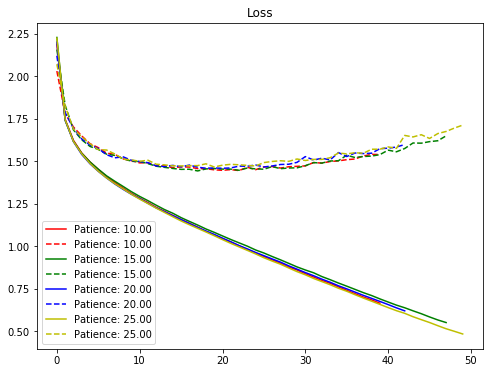

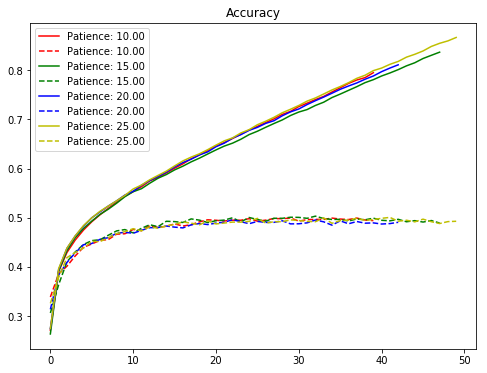

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()